In [2]:
import tensorflow as tf
print(tf.__version__)

gpu=tf.config.experimental.list_physical_devices('GPU')
for i in gpu:
    tf.config.experimental.set_memory_growth(i, True)

2.0.0


# 预测房价：回归问题

在前面的两个例子中，我们考虑了分类问题，另一种常见的机器学习问题是“回归”，它包括预测一个连续的值，而不是一个离散的标签。例如，预测明天的温度。

不要混淆“回归”和“Logistic回归”算法：令人困惑的是，“Logistic回归”不是一种回归算法，而是一种分类算法。

# 波士顿房价数据集
我们将尝试预测上世纪70年代中期波士顿郊区的房价中值，考虑到当时市郊的一些数据，如犯罪率、当地房产税等。

我们将要使用的数据集与我们前面的两个例子有另一个有趣的区别：它只有很少的数据点，总共只有506个，分为404个训练样本和102个测试样本，而且输入数据中的每个“特征”(例如犯罪率是一个特征)都有一个不同的尺度。例如，有些值是比例，它的值在0到1之间，另一些值在1到12之间，另一些值在0到100之间.


In [4]:
# 3-24加载数据
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [5]:
train_data.shape

(404, 13)

In [6]:
test_data.shape

(102, 13)

# 
我们有404个训练样本和102个测试样本。数据包括13个特征。


In [7]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

# 准备数据
将取值范围差异很大的数据输入到神经网络中，网络也许能够自动适应这样的取值范围不同的数据，但它肯定会使学习更加困难。处理这类数据的一个广泛的最佳方法是对特征进行规范化：对于输入数据中的每个特征(输入数据矩阵中的一列)，我们将减去特征的平均值并除以标准差，这样得到的特征平均值为0，标准差为1。

In [8]:
# 3-25数据标准化
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

# 
注意，我们只对训练数据集进行标准化处理，不对测试数据集进行处理。

# 建立我们的网络
由于可用的样本太少，我们将使用一个非常小的网络，其中包含两个隐藏层，每个层有64个单元。一般来说，你拥有的训练数据越少，越容易过拟合，使用一个小的网络是减少过拟合的一种方法。

In [9]:
# 3-26模型定义
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():

    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# 
我们的网络以一个单元结束，没有激活函数(即它将是线性层)。这是标量回归的一种典型设置(即，我们试图预测单个连续值的回归)。应用激活函数将限制输出的范围；例如，如果我们应用了sigmoid激活函数到最后一层，网络只能学习预测0到1之间的值。在这里，由于最后一层是纯线性的，所以网络可以自由地学习在任何范围内预测值。

注意，我们正在用mse损失函数（均方误差），预测与目标差的平方，回归问题中广泛使用的损失函数。

我们还在训练期间监测一项新的指标：mae。这代表平均绝对误差。它仅仅是预测值和目标差的绝对值。例如，如果对这个问题的预测值为0.5，就意味着我们的预测平均下降了500美元。

# 使用K折验证验证我们的方法
为了评估我们的网络，同时我们不断地调整它的参数，我们可以简单地将数据分成一个训练集和一个验证集，就像我们在前面的例子中所做的那样。但是，由于我们的数据点太少，验证集最终将变得非常小(例如，大约100个示例)。其结果是，我们的验证分数可能会根据以下情况发生很大的变化。哪一个我们选择用于验证的数据点，以及我们选择用于训练的数据点，即验证分数可能很高。验证集的划分方式可能会造成很大的方差，这样就无法对模型进行评估。

在这种情况下，最佳做法是使用K折叠交叉验证。它包括将可用数据分割为K个分区(通常为K=4或5)，然后实例化K个相同的模型，将每个模型在K-1个分区上进行训练，对剩下的一个分区进行评估。然后，所使用的模型的验证分数将是所获得的K验证分数的平均值。


In [10]:
# 3-27k折验证
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # 准备验证数据：第k个分区的数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 准备训练数据：其他所有分区的数据
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 构建模型
    model = build_model()
    # 训练模型
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 在验证数据上评估模型
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [11]:
all_scores

[2.1313875, 2.9395106, 3.0007832, 2.4701467]

In [12]:
np.mean(all_scores)

2.635457

# 
您可以注意到，不同的运行确实显示出不同的验证分数，从2.1到2.9。他们的平均值(2.4)比任何一个分数都要可靠得多--这就是K倍交叉验证的全部要点。在这种情况下，我们 2,400𝑜𝑛𝑎𝑣𝑒𝑟𝑎𝑔𝑒,𝑤ℎ𝑖𝑐ℎ𝑖𝑠𝑠𝑡𝑖𝑙𝑙𝑠𝑖𝑔𝑛𝑖𝑓𝑖𝑐𝑎𝑛𝑡𝑐𝑜𝑛𝑠𝑖𝑑𝑒𝑟𝑖𝑛𝑔𝑡ℎ𝑎𝑡𝑡ℎ𝑒𝑝𝑟𝑖𝑐𝑒𝑠𝑟𝑎𝑛𝑔𝑒𝑓𝑟𝑜𝑚 10,000至50,000美元

让我们试着再训练一下网络：500个时代。为了记录模型在每个时期的表现，我们将修改我们的训练循环以保存每个时代的验证分数日志：

In [24]:
# 3-28保存每折的验证结果
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # 准备验证数据：第k个分区的数据
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 准备训练数据：其他所有分区的数据
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()

    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [25]:
# 3-29计算所有轮次中的k折验证分数平均值
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

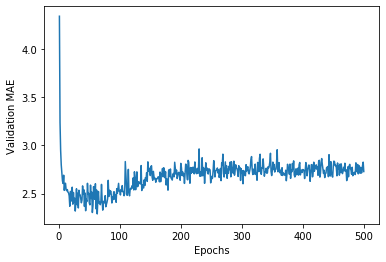

In [27]:
# 3-30绘制验证分数
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# 
由于缩放问题和相对较高的差异，可能很难看到情节。让我们：

省略前10个数据点，这些数据点的比例与曲线的其余部分不同。
用前几个点的指数移动平均值代替每个点，得到一条光滑的曲线。

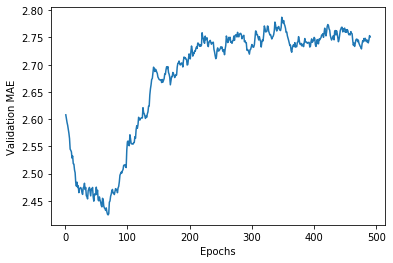

In [28]:
# 3-31绘制验证分数（删除前10个数据点）
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# 
由图可知在80轮后不再显著降低，之后就开始过拟合。

In [29]:
# 3-32训练最终模型
model = build_model()

model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [30]:
# 得出预测的房价和实际价格的差值
test_mae_score

2.5494912

# 结论
回归问题使用的损失函数一般时均方差误差

回归问题使用的评估指标也与分类问题不同，精度的概念不再适用，常见的指标时平均绝对值误差（MAE）

如果输入数据的特征具有不同的取值范围，应该先进行预处理，对每个特征单独进行缩放

如果可用的数据较少，可以使用K折验证评估模型

如果可用的数据较少，最好使用隐藏层较少的小型网络，避免过拟合

如果数据被分为多个类别，中间层过小可能会导致信息瓶颈